# Pseudo-time analysis

Hyperelastic materials experience substantial deformations, resulting in highly nonlinear responses. Pseudo time analysis facilitates the simulation of these significant deformations while ensuring numerical accuracy throughout the process. It addresses the inherent nonlinearity of the stress-strain relationship in hyperelastic materials.

In [189]:
def sigma(u):
    I = Identity(u.geometric_dimension())
    F = variable(grad(u) + I)
    J = det(F)
    C = F.T * F
    I1 = tr(C)
    energy = (mu / 2) * (I1 - 2) - mu * ln(J) + (lmbda / 2) * ln(J)**2
    return 2 * diff(energy, F)

def get_reaction_force(mesh):
    mf = MeshFunction("size_t",mesh,1)
    mf.set_all(0)
    clamped_boundary.mark(mf,1)
    ds = Measure("ds",subdomain_data=mf)
    # Define the Neumann boundary condition for the traction vector
    n=FacetNormal(mesh)
    traction = dot(sigma(u), n)
    # Integrate to get the traction vector
    reaction = assemble(traction[1] * ds(1))
    return reaction

In [190]:
from dolfin import *
from matplotlib import pyplot as plt
# Create mesh and define function space

length, depth = 3000, 300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Mark boundary subdomians
clamped_boundary = CompiledSubDomain("near(x[0],0)")
load_boundary = CompiledSubDomain("near(x[0],3000)")

# Define Dirichlet boundary (x = 0 or x = 1)
fixed = Expression(("0.0", "0.0"), degree=1)
load = Expression(("-disp_step*t"), disp_step=100, t=1, degree=1)

bcl = DirichletBC(V, fixed, clamped_boundary)
bcr = DirichletBC(V.sub(1), load, load_boundary)
bcs = [bcl, bcr]

# Define functions
du = TrialFunction(V)            # Incremental displacement
v = TestFunction(V)             # Test function
u = Function(V)                 # Displacement from previous iteration
B = Constant((0.0, 0.0))  # Body force per unit volume
T = Constant((0.0, 0.0))  # Traction force on the boundary

# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

# Elasticity parameters
E, nu = 1, 0.45
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# Compute solution
problem = NonlinearVariationalProblem(F, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['maximum_iterations'] = 1000
prm['newton_solver']['linear_solver'] = 'gmres'
prm['newton_solver']['preconditioner'] = 'hypre_euclid'
prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000

reaction_force = []
displacement = []
for t in range(0,30):
    load.t = t
    solver.solve()
    displacement.append(load.t)
    reaction_force.append(get_reaction_force(mesh))

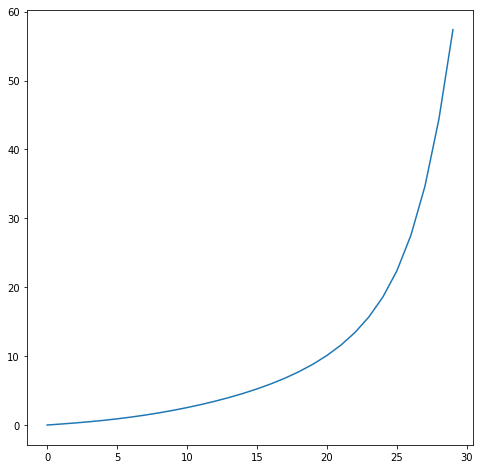

In [191]:
plt.figure(figsize=(8, 8))
plt.plot(displacement,reaction_force)

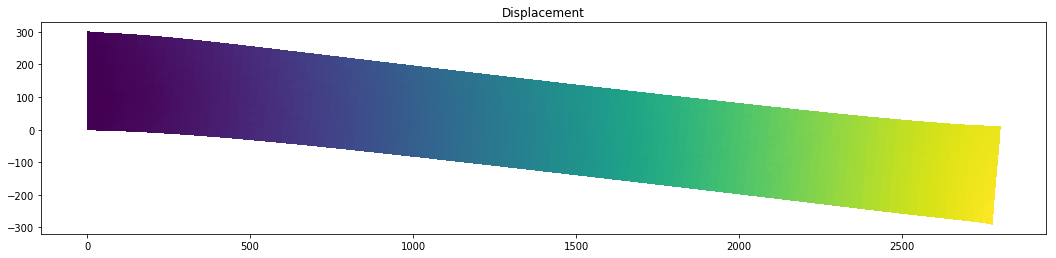

In [192]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 1/10
plot(u*scale_factor, title='Displacement', mode='displacement')